In [28]:
import pennylane as qml
import numpy as np

def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

n_wires = 4
n_block_wires = 2
n_params_block = 2
n_blocks = qml.MPS.get_n_blocks(range(n_wires),n_block_wires)
one_block = qml.MPS.get_n_blocks(range(n_wires)[-3:],2)
template_weights = [[0.1, -0.3]] * n_blocks
template_weights_one = [[0.1, -0.3]] * one_block

dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit(template_weights):
    qml.MPS(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    qml.WireCut(wires=range(n_wires)[-3:])
    qml.MPS(range(n_wires)[-3:],one_block,block, n_params_block, template_weights_one)
    return qml.expval(qml.Z(0) @ qml.Z(1) @ qml.Z(2) @ qml.Z(3))

print(qml.draw(circuit, show_matrices=False)(template_weights))

0: ─╭MPS(M0)──────────────┤ ╭<Z@Z@Z@Z>
1: ─├MPS(M0)─╭//─╭MPS(M1)─┤ ├<Z@Z@Z@Z>
2: ─├MPS(M0)─├//─├MPS(M1)─┤ ├<Z@Z@Z@Z>
3: ─╰MPS(M0)─╰//─╰MPS(M1)─┤ ╰<Z@Z@Z@Z>


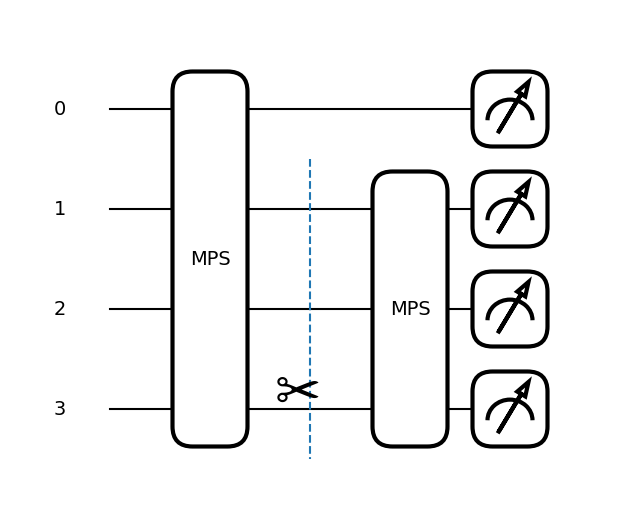

In [29]:
fig1, ax = qml.draw_mpl(circuit, show_matrices=False)(template_weights)

In [31]:
circuit(template_weights)

0.8120378120476952

In [34]:
from ricco.algorithm import RICCO
num_cuts = 3
# Initialize RICCO
ricco = RICCO(circuit, num_cuts, dev, entangling_layers=4)
ricco.reconstruct()
ricco.expval

Optimization complete!


0.5614956110153206

In [35]:
from ricco.algorithm import RICCO
num_cuts = 3
# Initialize RICCO
ricco = RICCO(circuit, num_cuts, dev, entangling_layers=3)

# Run multiple trials and compute the average expectation value
ricco.run_multiple_trials(iterations=5)

# Access the mean expectation value
print("Mean Expectation Value (from attribute):", ricco.mean_expval)

Optimization complete!
Iteration 1/5, Expectation Value: 0.6654392348994491
Optimization complete!
Iteration 2/5, Expectation Value: 0.7627749541002387
Optimization complete!
Iteration 3/5, Expectation Value: 0.5702643742581566
Optimization complete!
Iteration 4/5, Expectation Value: 0.6170274206268312
Optimization complete!
Iteration 5/5, Expectation Value: 0.49616615672615405
Mean Expectation Value over 5 iterations: 0.6223344281221659
Mean Expectation Value (from attribute): 0.6223344281221659


In [16]:
# print(qml.draw(circuit)(template_weights))

/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/qnode.py:830: PennyLaneDeprecationWarning: The tape/qtape property is deprecated and will be removed in v0.41. Instead, use the qml.workflow.construct_tape function.
  warnings.warn(


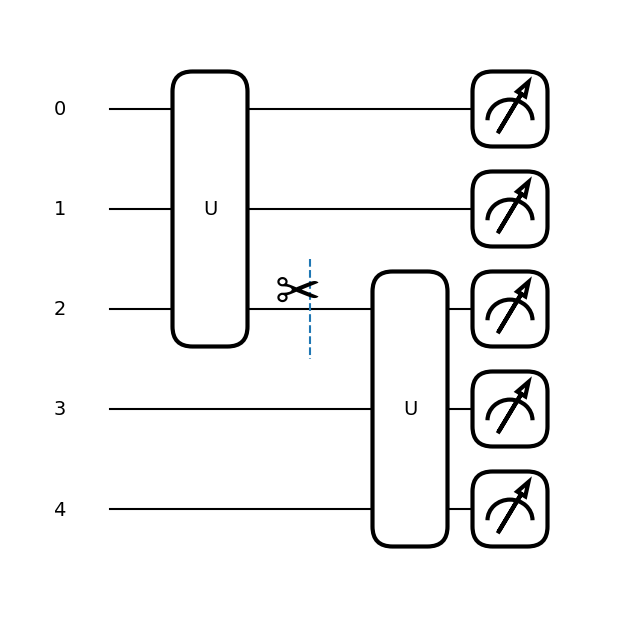

In [1]:
import pennylane as qml
from pennylane import numpy as np
from ricco.utils import generate_random_circuit

num_qubits = 5 # Total number of qubits in the circuit
num_cuts=1     # Number of cuts on the circuit
seed_u = 103   # Seed to generate the random unitary for upstream circuit
seed_v = 105   # Seed to generate the random unitary for downstream circuit

# Initialize device for RICCO optimization
dev = qml.device("default.qubit", wires=range(num_qubits))

# Define and create a QNode for the generated quantum circuit
random_circuit_qnode = qml.QNode(generate_random_circuit, device=dev)

# Update QNode and Compute expectation value of the uncut circuit
uncut_random_circuit_expval = random_circuit_qnode(
    num_qubits, num_cuts, seed_u, seed_v)

# Optionally display the uncut circuit
fig1, ax = qml.draw_mpl(random_circuit_qnode)(num_qubits, num_cuts, 
                                              seed_u, seed_v)

tape = random_circuit_qnode.qtape

In [2]:
from ricco.algorithm import RICCO
# Initialize RICCO
ricco = RICCO(random_circuit_qnode, num_cuts, dev, entangling_layers=3)

# Run multiple trials and compute the average expectation value
ricco.run_multiple_trials(iterations=1)

# Access the mean expectation value
print("Mean Expectation Value (from attribute):", ricco.mean_expval)

Optimization complete!
Iteration 1/1, Expectation Value: 0.1408930879312773
Mean Expectation Value over 1 iterations: 0.1408930879312773
Mean Expectation Value (from attribute): 0.1408930879312773


/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/execution.py:161: PennyLaneDeprecationWarning: gradient_fn has been renamed to diff_method in qml.execute
  warn(


In [3]:
qml.execute([tape], dev)

(0.13896967694463053,)

In [4]:
ricco.update_and_expand_fragment_tapes()
for c in ricco.expanded_tapes:
    print(c.draw(show_matrices=False))
    print()

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@I>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@I>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@I>

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@Z>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@Z>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@Z>

2: ──I──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>

2: ──X──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>

